In [1]:
import numpy as np
import pandas as pd
import time
from datasets import load_dataset
from transformers import get_cosine_schedule_with_warmup
from tqdm import notebook
from sklearn.model_selection import KFold
import os
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoModel
from transformers import AutoTokenizer
from transformers import AutoConfig

import gc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset = load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')
df = dataset['train'].to_pandas()
df.describe()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/ucberkeley-dlab--measuring-hate-speech-2d735043be36d4ff/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target

In [4]:
len(df['comment_id'].unique())

39565

In [5]:
len(df['annotator_id'].unique())

7912

In [6]:
df.head()

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False


In [7]:
df[df['comment_id'] == 43625][['hate_speech_score', 'hatespeech']]

,hate_speech_score,hatespeech
3,0.26,0.0
24412,0.26,0.0
49310,0.26,2.0
70100,0.26,0.0


<Axes: >

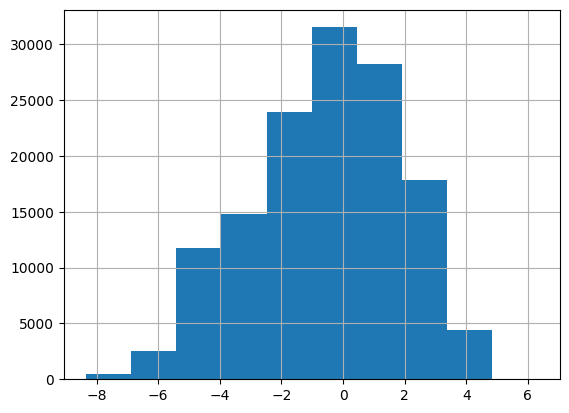

In [8]:
df['hate_speech_score'].hist()

In [9]:
df['hatespeech'].unique()

array([0., 2., 1.])

In [10]:
df[df['comment_id'] == 47101]['hate_speech_score']

2        0.36
25182    0.36
46708    0.36
69660    0.36
Name: hate_speech_score, dtype: float64

In [11]:
def get_agreement_score(x):
    mode_result = x.mode()
    mode_count = (x == mode_result.iloc[0]).sum()
    ln = len(x)
    
    return round(mode_count/ln*5)/5

In [12]:
text_df = df.groupby('comment_id', as_index=False).agg({'text': 'first', 'hate_speech_score': 'first', 'hatespeech': get_agreement_score})
text_df.columns = ['comment_id', 'text', 'hate_speech_score', 'annotator_agreement_factor']
text_df.head()

,comment_id,text,hate_speech_score,annotator_agreement_factor
0,1,White people are trash.,0.46,1.0
1,2,"You've caught the big gay, it's known to be ai...",0.03,0.6
2,3,"I'm not saying you said that, I'm just saying ...",-1.29,0.6
3,4,Donald Trump. Yeet myself off a building onto ...,-0.24,0.4
4,5,Fabrice Fabrice is ostensibly black or black/l...,-2.84,1.0


In [13]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39565 entries, 0 to 39564
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   comment_id                  39565 non-null  int32  
 1   text                        39565 non-null  object 
 2   hate_speech_score           39565 non-null  float64
 3   annotator_agreement_factor  39565 non-null  float64
dtypes: float64(2), int32(1), object(1)
memory usage: 1.1+ MB


In [14]:
def score_to_label(score):
    if score < -1:
        return 0
    if score > 0.5:
        return 2
    return 1

In [15]:
text_df['label'] = text_df['hate_speech_score'].apply(lambda x:score_to_label(x))
text_df.head()

,comment_id,text,hate_speech_score,annotator_agreement_factor,label
0,1,White people are trash.,0.46,1.0,1
1,2,"You've caught the big gay, it's known to be ai...",0.03,0.6,1
2,3,"I'm not saying you said that, I'm just saying ...",-1.29,0.6,0
3,4,Donald Trump. Yeet myself off a building onto ...,-0.24,0.4,1
4,5,Fabrice Fabrice is ostensibly black or black/l...,-2.84,1.0,0


<Axes: >

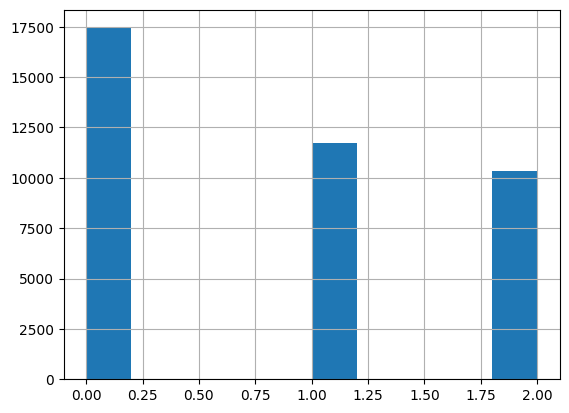

In [16]:
text_df['label'].hist()

<Axes: >

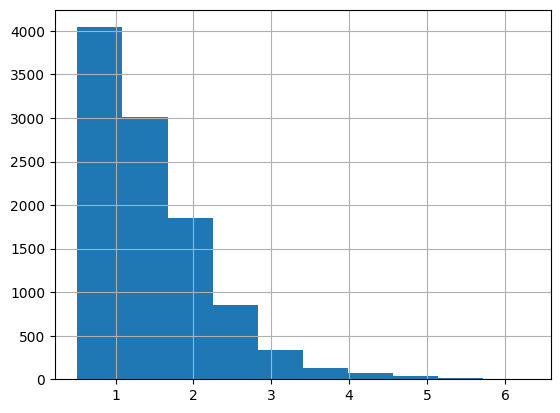

In [17]:
text_df[text_df['label'] == 2]['hate_speech_score'].hist()

In [18]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [19]:
SEED = 875
seed_everything(SEED)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

Device:  cuda


In [21]:
BERT = 'bert-base-uncased'
ROBERTA = 'roberta-base'

In [22]:
MODEL_NAME = ROBERTA

In [23]:
from sklearn.model_selection import StratifiedKFold, train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(text_df[['comment_id', 'text']], text_df.label, test_size=0.1, random_state=SEED, stratify=text_df.label)

In [25]:
print(X_train.shape, y_train.shape)

(35608, 2) (35608,)


In [67]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [68]:
# train_df_0 = train_df[train_df['label'] == 0].sample(frac=0.01)
# train_df_1 = train_df[train_df['label'] == 1].sample(frac=0.01)
# train_df_2 = train_df[train_df['label'] == 2].sample(frac=0.01)
# train_df = pd.concat([train_df_0, train_df_1, train_df_2], axis=0).reset_index(drop=True)
# len(train_df)

In [69]:
train_df.head()

,comment_id,text,label
0,18608,I agree. America would lose their collective s...,0
1,34922,"The Worlds Stupidest Policy, Yes. It can only ...",1
2,5088,Reddit doesn't care if they aren't white.,0
3,1372,"> Jesus chased profit-motive ""religious"" peopl...",0
4,36023,like i said its not gay if its in space right URL,1


In [70]:
len(train_df)

35608

<Axes: >

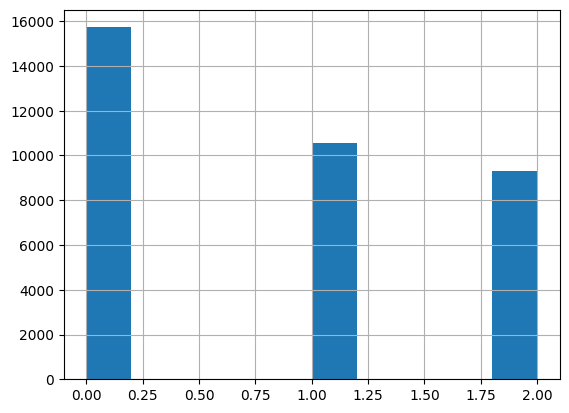

In [71]:
train_df['label'].hist()

In [72]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [85]:
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
MAX_LEN = 256
EPOCHS = 5
LEARNING_RATE = 5e-5
NUM_LABELS = 3
NUM_FOLDS = 5
EVAL_PERIOD = 200

In [74]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.len = len(df)
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = self.df.loc[index, 'text']
        text_id = self.df.loc[index, 'comment_id']
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if MODEL_NAME=='bert-base-uncased':
            token_type_ids = inputs['token_type_ids']
        else:
            token_type_ids = 1.

        target = self.df.loc[index, 'label']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'masks': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long),
            'text_ids': text_id
        }

    def __len__(self):
        return self.len


In [75]:
class HateSpeechClassifier(torch.nn.Module):
    def __init__(self, model_name, dropout=True):
        super(HateSpeechClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_name = model_name

        if model_name == BERT:
            self.in_features = self.bert.pooler.dense.out_features
        elif model_name == ROBERTA:
            self.in_features = self.bert.pooler.dense.out_features
        else:
            self.in_features = 768

        self.dense = nn.Linear(self.in_features, 64)
        self.activation = nn.ReLU()
#         self.layer_norm = nn.LayerNorm(self.in_features)
        self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(64, NUM_LABELS)

    def forward(self, input_ids, attention_mask, token_type_ids):
        if self.model_name == BERT:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  token_type_ids=token_type_ids,
                                                  return_dict=False)
        elif self.model_name == ROBERTA:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  return_dict=False)

        output = self.dense(output)
        output = self.activation(output)
#         output = self.layer_norm(output)
        output = self.dropout(output)
        output = self.classifier(output)
        # output = torch.nn.Softmax(output)
        return output

In [76]:
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

valid_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

In [77]:
def get_train_setup(train_df, train_indices, val_indices, n_folds=5):
    train_data = TextDataset(train_df.loc[train_indices].reset_index(drop=True), tokenizer, MAX_LEN)
    val_data = TextDataset(train_df.loc[val_indices].reset_index(drop=True), tokenizer, MAX_LEN)
    
    train_loader = DataLoader(train_data, **train_params)
    val_loader = DataLoader(val_data, **valid_params)
    
    model = HateSpeechClassifier(MODEL_NAME)
    model.to(device)
    
    num_training_steps = (EPOCHS-1)*len(train_loader)

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
    
    num_warmup_steps = 100
    scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_training_steps=num_training_steps,
        num_warmup_steps=num_warmup_steps,
    )
    
    return train_loader, val_loader, model, loss_function, optimizer, scheduler

In [78]:
test_data = TextDataset(test_df, tokenizer, MAX_LEN)
test_loader = DataLoader(test_data, **test_params)

In [79]:
def calc_accuracy(preds, targets):
    accuracy = (preds==targets).cpu().numpy().mean() * 100
    return accuracy

In [80]:
def get_cur_confidence(label, label_0, label_1, label_2):
    if label == 0:
        return label_0
    elif label == 1:
        return label_1
    else: return label_2
    
def get_cur_confidence_from_arr(label, arr):
    if label == 0:
        return arr[1]
    elif label == 1:
        return arr[2]
    else: return arr[3]

def get_train_loader(train_confidence_values, train_df, epoch, cur_train_values_df):
    print(train_confidence_values.size())
    cur_train_values = [0] * len(train_confidence_values)
    for i, v in enumerate(train_confidence_values):
        cur_train_values[i] = v.cpu().detach().numpy()
        
    if epoch == 0:
        cur_train_values_df = pd.DataFrame(cur_train_values, columns=['comment_id', 'label_0', 'label_1', 'label_2'])
        cur_train_values_df = pd.merge(cur_train_values_df, text_df[['comment_id', 'label']], on='comment_id', how='left')
        cur_train_values_df['confidence'] = cur_train_values_df.apply(lambda row: get_cur_confidence(row.label, row.label_0, row.label_1, row.label_2), axis=1)
    else:
        for val in cur_train_values:
            label = cur_train_values_df[cur_train_values_df['comment_id'] == val[0]].label.item()
            cur_train_values_df.loc[cur_train_values_df['comment_id'] == val[0], 'confidence'] = get_cur_confidence_from_arr(label, val)
    
    # sampling from cur_train_values_df based on confidence score of model
    temp_train_df_0 = cur_train_values_df[cur_train_values_df['confidence'] <= 0.5].sample(frac=1)
    
#     temp_train_df_1 = cur_train_values_df[(cur_train_values_df['confidence'] <= 0.75) & (cur_train_values_df['confidence'] > 0.5) & (cur_train_values_df['label'] == 0)].sample(frac=0.5)
#     temp_train_df_2 = cur_train_values_df[(cur_train_values_df['confidence'] <= 0.75) & (cur_train_values_df['confidence'] > 0.5) & (cur_train_values_df['label'] == 1)].sample(frac=0.5)
#     temp_train_df_3 = cur_train_values_df[(cur_train_values_df['confidence'] <= 0.75) & (cur_train_values_df['confidence'] > 0.5) & (cur_train_values_df['label'] == 2)].sample(frac=0.5)
    
#     temp_train_df_4 = cur_train_values_df[(cur_train_values_df['confidence'] > 0.75) & (cur_train_values_df['label'] == 0)].sample(frac=0.2)
#     temp_train_df_5 = cur_train_values_df[(cur_train_values_df['confidence'] > 0.75) & (cur_train_values_df['label'] == 1)].sample(frac=0.2)
#     temp_train_df_6 = cur_train_values_df[(cur_train_values_df['confidence'] > 0.75) & (cur_train_values_df['label'] == 2)].sample(frac=0.2)

    mn = min([len(cur_train_values_df[(cur_train_values_df['confidence'] > 0.5) & (cur_train_values_df['label'] == 0)]),
             len(cur_train_values_df[(cur_train_values_df['confidence'] > 0.5) & (cur_train_values_df['label'] == 1)]),
             len(cur_train_values_df[(cur_train_values_df['confidence'] > 0.5) & (cur_train_values_df['label'] == 2)])]
            )
    
    temp_train_df_1 = cur_train_values_df[(cur_train_values_df['confidence'] > 0.5) & (cur_train_values_df['label'] == 0)].sample(int(mn*0.2))
    temp_train_df_2 = cur_train_values_df[(cur_train_values_df['confidence'] > 0.5) & (cur_train_values_df['label'] == 1)].sample(int(mn*0.2))
    temp_train_df_3 = cur_train_values_df[(cur_train_values_df['confidence'] > 0.5) & (cur_train_values_df['label'] == 2)].sample(int(mn*0.2))
    
    temp_train_df = pd.concat([temp_train_df_0, temp_train_df_1, temp_train_df_2, temp_train_df_3], axis=0).reset_index(drop=True)
    print(f"Original Train Len: {len(train_df)*0.8}, New Train Len: {len(temp_train_df)}")
    
    selected_comment_ids = temp_train_df['comment_id'].tolist()
    
    train_data = TextDataset(train_df[train_df['comment_id'].isin(selected_comment_ids)].reset_index(drop=True), tokenizer, MAX_LEN)
    train_loader = DataLoader(train_data, **train_params)
    
    return train_loader, cur_train_values_df

In [81]:
def train(model, model_output_path, loss_fn, optimizer, scheduler, train_dataloader, val_dataloader=None, epochs=5, evaluation=False):

    print("Training...\n")
    train_values = []
    
    best_val_loss = None
    best_val_accuracy = None
    cur_train_values_df = None
    
    for epoch in range(epochs):
        print(f"Length of Train Dataloader: {len(train_dataloader)}")
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        train_loss = []
        val_loss = None
        val_accuracy = None
        
        model.train()

        epoch_train_values = torch.empty(0, dtype=torch.float)
        
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            model.zero_grad()
            input_ids = batch['ids'].to(device, dtype = torch.long)
            attention_mask = batch['masks'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            text_ids = batch['text_ids'].unsqueeze(1)

            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            train_loss.append(loss.item())

            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()             
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            softmax_values = torch.nn.functional.softmax(outputs, dim=1)

            batch_train_values = torch.cat((text_ids, softmax_values.cpu()), dim=1)
            epoch_train_values = torch.cat((epoch_train_values, batch_train_values), dim = 0)

            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
                
            if evaluation == True and ((step % EVAL_PERIOD == 0 and step != 0) or (step == len(train_dataloader) - 1)):
                val_loss, val_accuracy = evaluate(model, loss_fn, val_dataloader)
                time_elapsed = time.time() - t0_epoch
                
                if not best_val_loss or val_loss < best_val_loss:                    
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), model_path)
                    
                if not best_val_accuracy or val_accuracy > best_val_accuracy:                    
                    best_val_accuracy = val_accuracy
                
                print(f"\n Validation Loss: {val_loss:^10.6f} | Validation Accuracy: {val_accuracy:^9.2f} | Time elasped: {time_elapsed:^9.2f}\n")


        avg_train_loss = total_loss / len(train_dataloader)
        print(f"{epoch + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {best_val_loss:^10.6f} | {best_val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

        print("-"*70)

        train_values.append(epoch_train_values)
        print("\n")
        
        train_dataloader, cur_train_values_df = get_train_loader(epoch_train_values, train_df, epoch, cur_train_values_df)
        

    print("Training complete!")
    return train_values, best_val_loss, best_val_accuracy


In [82]:
def evaluate(model, loss_fn, val_dataloader):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        val_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        val_accuracy.append(calc_accuracy(max_ids, targets))

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [83]:
def predict(model, loss_fn, dataloader):
    model.eval()

    test_accuracy = []
    test_loss = []
    test_preds = []

    for batch in dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        test_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        test_accuracy.append(calc_accuracy(max_ids, targets))
        test_preds.append([max_ids.cpu().detach().numpy().reshape(-1), targets.cpu().detach().numpy().reshape(-1)])

    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy, test_preds

In [86]:
gc.collect()

kfold = KFold(n_splits=NUM_FOLDS, random_state=SEED, shuffle=True)
val_losses = []
val_accuracies = []
train_values_folds = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(train_df)):
    print(f"\nFold {fold + 1}/{NUM_FOLDS}\n\n")
    model_path = f"model_{MODEL_NAME}_{fold + 1}_hate_speech_cls.pth"
    
    train_loader, val_loader, model, loss_function, optimizer, scheduler = get_train_setup(
        train_df, 
        train_indices, 
        val_indices, 
        NUM_FOLDS
    )
    
    train_values, best_val_loss, best_val_accuracy = train(
        model, 
        model_path, 
        loss_function, 
        optimizer, 
        scheduler, 
        train_loader, 
        val_loader, 
        epochs=EPOCHS, 
        evaluation=True
    )
    
    val_losses.append(best_val_loss)
    val_accuracies.append(best_val_accuracy)
    train_values_folds.append(train_values)
    
#     del model
#     gc.collect()

    break
    
    print("\nAverage Performance across Folds:")
    print(val_losses)
    print("Mean:", np.array(val_losses).mean())



Fold 1/5




Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training...

Length of Train Dataloader: 891
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.106802   |     -      |     -     |   15.95  
   1    |   40    |   1.093119   |     -      |     -     |   15.24  
   1    |   60    |   1.066621   |     -      |     -     |   15.26  
   1    |   80    |   0.980496   |     -      |     -     |   15.33  
   1    |   100   |   0.920643   |     -      |     -     |   15.27  
   1    |   120   |   0.876259   |     -      |     -     |   15.32  
   1    |   140   |   0.877695   |     -      |     -     |   15.27  
   1    |   160   |   0.900193   |     -      |     -     |   15.28  
   1    |   180   |   0.883573   |     -      |     -     |   15.24  
   1    |   200   |   0.889411   |     -      |     -     |   15.25  

 Validation Loss:  0.878406  | Validation Accuracy:   60.47   | Time elasped:  211.12  

   1    |   220   |   0.

In [87]:
test_loss, test_accuracy, test_preds = predict(model, loss_function, test_loader)
test_loss, test_accuracy

(0.8642578653750881, 64.56413210445469)

## Analysis with Dataset Cartography

In [88]:
preds = []
targets = []
for ele in test_preds:
    for p in ele[0]: preds.append(p)
    for p in ele[1]: targets.append(p)

preds_np = np.array(preds)
targets_np = np.array(targets)
print(preds_np.shape, targets_np.shape)

(3957,) (3957,)


In [89]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [90]:
print(f1_score(targets_np, preds_np, average="weighted"))

0.6512649051152669


In [91]:
print(classification_report(targets_np, preds_np,))

              precision    recall  f1-score   support

           0       0.79      0.74      0.77      1748
           1       0.46      0.57      0.51      1174
           2       0.67      0.57      0.62      1035

    accuracy                           0.65      3957
   macro avg       0.64      0.63      0.63      3957
weighted avg       0.66      0.65      0.65      3957



In [92]:
print(confusion_matrix(targets_np, preds_np))

[[1291  399   58]
 [ 276  668  230]
 [  59  382  594]]


In [93]:
train_values2 = [0] * len(train_values)
for i, v in enumerate(train_values):
    train_values2[i] = v.cpu().detach().numpy()

In [94]:
train_values3 = []
for i, v in enumerate(train_values2):
    for j, row in notebook.tqdm(enumerate(v)):
        row1 = np.append(row, i+1)
        train_values3.append(row1)
        
train_values_np = np.stack(train_values3, axis=0)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [95]:
def get_train_dfs(train_confidence_values, train_df, epoch, cur_train_values_df):
    print(train_confidence_values.size())
    cur_train_values = [0] * len(train_confidence_values)
    for i, v in enumerate(train_confidence_values):
        cur_train_values[i] = v.cpu().detach().numpy()
        
    if epoch == 0:
        cur_train_values_df = pd.DataFrame(cur_train_values, columns=['comment_id', 'label_0', 'label_1', 'label_2'])
        cur_train_values_df = pd.merge(cur_train_values_df, text_df[['comment_id', 'label']], on='comment_id', how='left')
        cur_train_values_df['confidence'] = cur_train_values_df.apply(lambda row: get_cur_confidence(row.label, row.label_0, row.label_1, row.label_2), axis=1)
    else:
        for val in cur_train_values:
            label = cur_train_values_df[cur_train_values_df['comment_id'] == val[0]].label.item()
            cur_train_values_df.loc[cur_train_values_df['comment_id'] == val[0], 'confidence'] = get_cur_confidence_from_arr(label, val)
    
    # sampling from cur_train_values_df based on confidence score of model
    temp_train_df_0 = cur_train_values_df[cur_train_values_df['confidence'] <= 0.5].sample(frac=1)
    
    temp_train_df_1 = cur_train_values_df[(cur_train_values_df['confidence'] <= 0.75) & (cur_train_values_df['confidence'] > 0.5) & (cur_train_values_df['label'] == 0)].sample(frac=0.5)
    temp_train_df_2 = cur_train_values_df[(cur_train_values_df['confidence'] <= 0.75) & (cur_train_values_df['confidence'] > 0.5) & (cur_train_values_df['label'] == 1)].sample(frac=0.5)
    temp_train_df_3 = cur_train_values_df[(cur_train_values_df['confidence'] <= 0.75) & (cur_train_values_df['confidence'] > 0.5) & (cur_train_values_df['label'] == 2)].sample(frac=0.5)
    
    temp_train_df_4 = cur_train_values_df[(cur_train_values_df['confidence'] > 0.75) & (cur_train_values_df['label'] == 0)].sample(frac=0.2)
    temp_train_df_5 = cur_train_values_df[(cur_train_values_df['confidence'] > 0.75) & (cur_train_values_df['label'] == 1)].sample(frac=0.2)
    temp_train_df_6 = cur_train_values_df[(cur_train_values_df['confidence'] > 0.75) & (cur_train_values_df['label'] == 2)].sample(frac=0.2)
    
    temp_train_df = pd.concat([temp_train_df_0, temp_train_df_1, temp_train_df_2, temp_train_df_3, temp_train_df_4, temp_train_df_5, temp_train_df_6], axis=0).reset_index(drop=True)
    print(f"Original Train Len: {len(train_df)*0.8}, New Train Len: {len(temp_train_df)}")
    
#     selected_comment_ids = temp_train_df['comment_id'].tolist()
    
#     train_data = TextDataset(train_df[train_df['comment_id'].isin(selected_comment_ids)].reset_index(drop=True), tokenizer, MAX_LEN)
#     train_loader = DataLoader(train_data, **train_params)
    
    return temp_train_df, cur_train_values_df

In [96]:
# temp_train_df1, cur_train_values_df1 = get_train_dfs(train_values[2], train_df, 1, cur_train_values_df1)

NameError: name 'cur_train_values_df1' is not defined

In [97]:
# temp_train_df1

NameError: name 'temp_train_df1' is not defined

In [98]:
# len(cur_train_values_df1[(cur_train_values_df1['confidence'] <= 0.5) & (cur_train_values_df1['label'] == 0)])

In [99]:
train_values_np.shape

(72502, 5)

In [100]:
train_values_df = pd.DataFrame(train_values_np, columns=['comment_id', 'label_0', 'label_1', 'label_2', 'epoch_no'])
train_values_df.head()

,comment_id,label_0,label_1,label_2,epoch_no
0,26947.0,0.334558,0.292120,0.373322,1.0
1,47632.0,0.348352,0.259599,0.392049,1.0
2,22354.0,0.345993,0.290516,0.363491,1.0
3,47240.0,0.334455,0.279395,0.386150,1.0
4,3440.0,0.338227,0.304014,0.357759,1.0


In [101]:
train_values_df['comment_id'] = train_values_df['comment_id'].astype(int)
train_values_df['epoch_no'] = train_values_df['epoch_no'].astype(int)
train_values_df.head()

,comment_id,label_0,label_1,label_2,epoch_no
0,26947,0.334558,0.292120,0.373322,1
1,47632,0.348352,0.259599,0.392049,1
2,22354,0.345993,0.290516,0.363491,1
3,47240,0.334455,0.279395,0.386150,1
4,3440,0.338227,0.304014,0.357759,1


In [102]:
train_values_df = pd.merge(train_values_df, text_df[['comment_id', 'label', 'hate_speech_score', 'annotator_agreement_factor']], on='comment_id', how='left')
train_values_df.head()

,comment_id,label_0,label_1,label_2,epoch_no,label,hate_speech_score,annotator_agreement_factor
0,26947,0.334558,0.292120,0.373322,1,1,-0.29,1.0
1,47632,0.348352,0.259599,0.392049,1,1,-0.63,0.4
2,22354,0.345993,0.290516,0.363491,1,1,0.14,1.0
3,47240,0.334455,0.279395,0.386150,1,2,2.72,1.0
4,3440,0.338227,0.304014,0.357759,1,1,0.12,1.0


In [103]:
def get_pred(label_0, label_1, label_2):
    if label_0> label_1 and label_0 > label_2:
        return 0
    elif label_1> label_0 and label_1 > label_2:
        return 1
    else:
        return 2

In [104]:
train_values_df['pred'] = train_values_df.apply(lambda row: get_pred(row.label_0, row.label_1, row.label_2), axis=1)

In [105]:
train_values_df.tail()

,comment_id,label_0,label_1,label_2,epoch_no,label,hate_speech_score,annotator_agreement_factor,pred
72497,20751,0.016733,0.207151,0.776115,5,1,-0.01,0.4,2
72498,23781,0.093445,0.849136,0.057419,5,1,-0.58,1.0,1
72499,27630,0.016612,0.055350,0.928038,5,2,1.31,1.0,2
72500,34875,0.976798,0.013696,0.009505,5,0,-3.05,1.0,0
72501,22649,0.048345,0.549577,0.402079,5,2,1.34,0.4,1


In [106]:
train_values_agg_df = train_values_df.sort_values(['epoch_no']).groupby('comment_id', as_index=False).agg({'label_0': ['mean', 'std', 'last'], 'label_1': ['mean', 'std', 'last'], 'label_2': ['mean', 'std', 'last'], 'label': 'first', 'hate_speech_score': 'first', 'pred': 'last', 'annotator_agreement_factor': 'first'})

In [107]:
train_values_agg_df.head()

comment_id   label_0                       label_1                      \
                  mean       std      last      mean       std      last   
0          1  0.141049  0.012492  0.149882  0.478217  0.157787  0.589790   
1          2  0.303261  0.178624  0.220003  0.533481  0.128272  0.668805   
2          3  0.637189  0.269390  0.827676  0.280039  0.176347  0.155344   
3          5  0.911993       NaN  0.911993  0.076303       NaN  0.076303   
4          6  0.292068  0.231878  0.025712  0.376405  0.099756  0.269776   

    label_2                     label hate_speech_score pred  \
       mean       std      last first             first last   
0  0.380734  0.170280  0.260328     1              0.46    1   
1  0.163258  0.120066  0.111192     1              0.03    1   
2  0.082772  0.093043  0.016980     0             -1.29    0   
3  0.011703       NaN  0.011703     0             -2.84    0   
4  0.331527  0.328792  0.704513     2              1.72    2   

  annotator_agreement_factor  
                       first  
0                        1.0  
1                        0.6  
2                        0.6  
3                        1.0  
4                        1.0

In [108]:
train_values_agg_df.columns = ['comment_id', 'label_0_mean', 'label_0_std', 'label_0_last', 'label_1_mean', 'label_1_std', 'label_1_last', 'label_2_mean', 'label_2_std', 'label_2_last', 'label', 'hate_speech_score', 'pred', 'annotator_agreement_factor']
train_values_agg_df.head()

,comment_id,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label_2_mean,label_2_std,label_2_last,label,hate_speech_score,pred,annotator_agreement_factor
0,1,0.141049,0.012492,0.149882,0.478217,0.157787,0.589790,0.380734,0.170280,0.260328,1,0.46,1,1.0
1,2,0.303261,0.178624,0.220003,0.533481,0.128272,0.668805,0.163258,0.120066,0.111192,1,0.03,1,0.6
2,3,0.637189,0.269390,0.827676,0.280039,0.176347,0.155344,0.082772,0.093043,0.016980,0,-1.29,0,0.6
3,5,0.911993,NaN,0.911993,0.076303,NaN,0.076303,0.011703,NaN,0.011703,0,-2.84,0,1.0
4,6,0.292068,0.231878,0.025712,0.376405,0.099756,0.269776,0.331527,0.328792,0.704513,2,1.72,2,1.0


In [109]:
def get_confidence(label, label_0_mean, label_1_mean, label_2_mean):
    if label == 0:
        return label_0_mean
    elif label == 1:
        return label_1_mean
    else: return label_2_mean
    
def get_variability(label, label_0_std, label_1_std, label_2_std):
    if label == 0:
        return label_0_std
    elif label == 1:
        return label_1_std
    else: return label_2_std

def get_correctness(label, label_0_last, label_1_last, label_2_last):
    if label == 0:
        return round(label_0_last*5)/5
    elif label == 1:
        return round(label_1_last*5)/5
    else: return round(label_2_last*5)/5

In [110]:
train_values_agg_df['confidence'] = train_values_agg_df.apply(lambda row: get_confidence(row.label, row.label_0_mean, row.label_1_mean, row.label_2_mean), axis=1)
train_values_agg_df['variability'] = train_values_agg_df.apply(lambda row: get_variability(row.label, row.label_0_std, row.label_1_std, row.label_2_std), axis=1)
train_values_agg_df['correctness'] = train_values_agg_df.apply(lambda row: get_correctness(row.label, row.label_0_last, row.label_1_last, row.label_2_last), axis=1)
train_values_agg_df.head()

,comment_id,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label_2_mean,label_2_std,label_2_last,label,hate_speech_score,pred,annotator_agreement_factor,confidence,variability,correctness
0,1,0.141049,0.012492,0.149882,0.478217,0.157787,0.589790,0.380734,0.170280,0.260328,1,0.46,1,1.0,0.478217,0.157787,0.6
1,2,0.303261,0.178624,0.220003,0.533481,0.128272,0.668805,0.163258,0.120066,0.111192,1,0.03,1,0.6,0.533481,0.128272,0.6
2,3,0.637189,0.269390,0.827676,0.280039,0.176347,0.155344,0.082772,0.093043,0.016980,0,-1.29,0,0.6,0.637189,0.269390,0.8
3,5,0.911993,NaN,0.911993,0.076303,NaN,0.076303,0.011703,NaN,0.011703,0,-2.84,0,1.0,0.911993,NaN,1.0
4,6,0.292068,0.231878,0.025712,0.376405,0.099756,0.269776,0.331527,0.328792,0.704513,2,1.72,2,1.0,0.331527,0.328792,0.8


In [111]:
train_values_agg_df['is_correct'] = np.where((train_values_agg_df['label'] == train_values_agg_df['pred']), True, False)
train_values_agg_df.head()

,comment_id,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label_2_mean,label_2_std,label_2_last,label,hate_speech_score,pred,annotator_agreement_factor,confidence,variability,correctness,is_correct
0,1,0.141049,0.012492,0.149882,0.478217,0.157787,0.589790,0.380734,0.170280,0.260328,1,0.46,1,1.0,0.478217,0.157787,0.6,True
1,2,0.303261,0.178624,0.220003,0.533481,0.128272,0.668805,0.163258,0.120066,0.111192,1,0.03,1,0.6,0.533481,0.128272,0.6,True
2,3,0.637189,0.269390,0.827676,0.280039,0.176347,0.155344,0.082772,0.093043,0.016980,0,-1.29,0,0.6,0.637189,0.269390,0.8,True
3,5,0.911993,NaN,0.911993,0.076303,NaN,0.076303,0.011703,NaN,0.011703,0,-2.84,0,1.0,0.911993,NaN,1.0,True
4,6,0.292068,0.231878,0.025712,0.376405,0.099756,0.269776,0.331527,0.328792,0.704513,2,1.72,2,1.0,0.331527,0.328792,0.8,True


In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

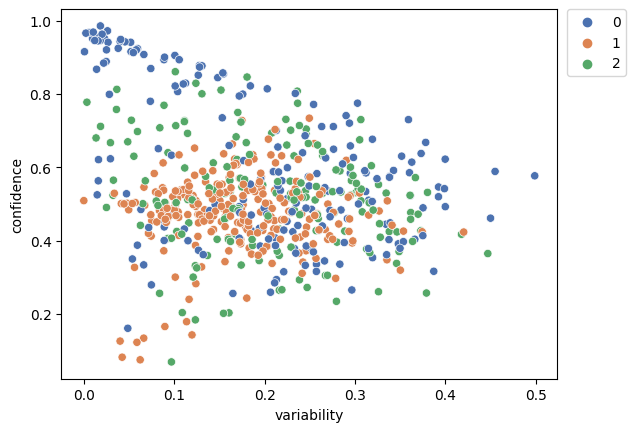

In [113]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='pred', palette='deep')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

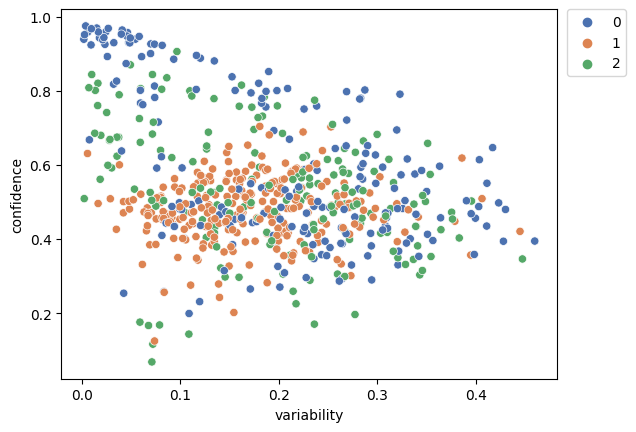

In [114]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='label', palette='deep')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

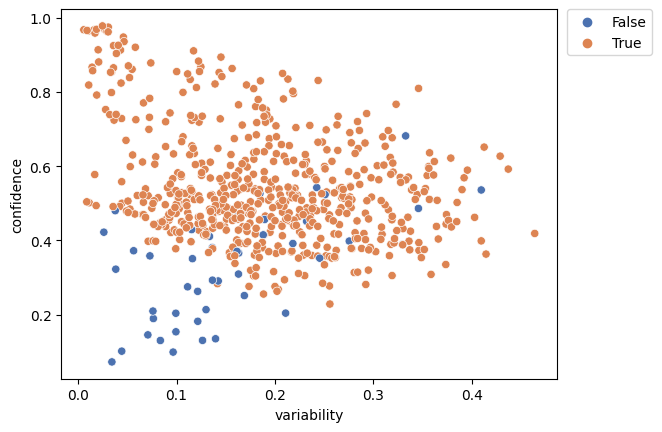

In [115]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='is_correct', palette='deep')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

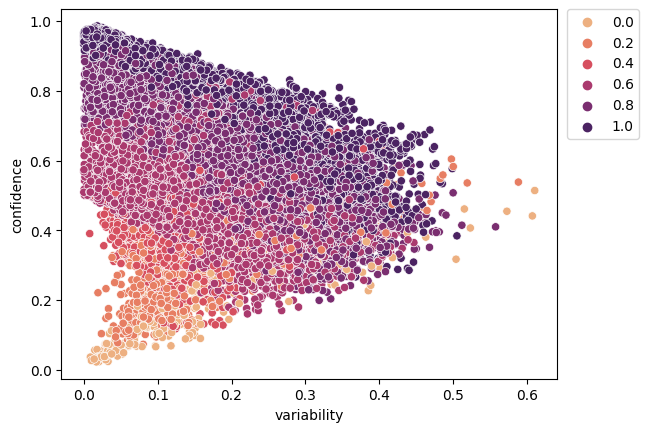

In [120]:
sns.scatterplot(data=train_values_agg_df, x="variability", y="confidence", hue='correctness', palette='flare')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

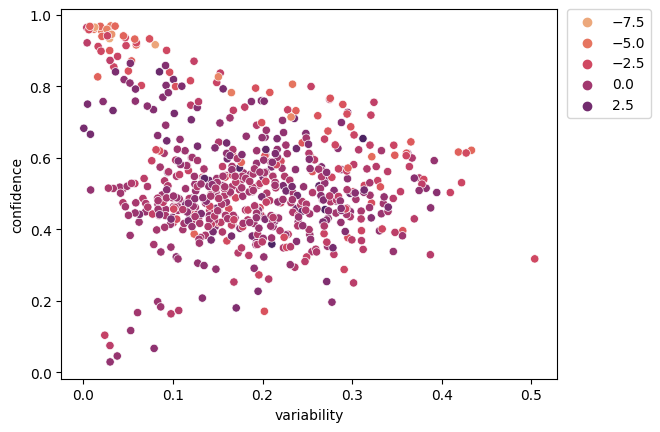

In [117]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='hate_speech_score', palette='flare')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

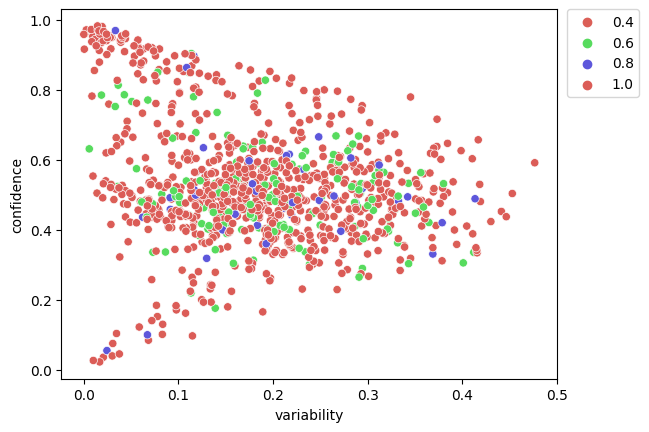

In [118]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.05), x="variability", y="confidence", hue='annotator_agreement_factor', palette='hls')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<Axes: >

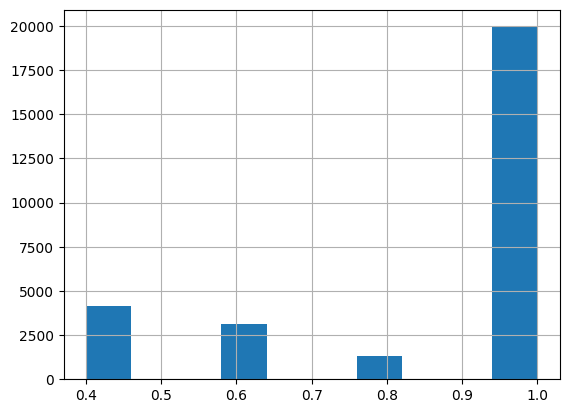

In [119]:
train_values_agg_df['annotator_agreement_factor'].hist()